# Procesamiento de lenguaje natural - Desafio 3
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje utilizando otro dataset y
poner en práctica la generación de secuencias con una de las estrategias presentadas.

In [ ]:
import os
import platform
import random
import io
import pickle
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy # For acurracy metric

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

### Datos
Utilizaremos como fuente de datos un dataset de prompts en inglés llamado "ultrachat":

https://www.kaggle.com/datasets/thedevastator/ultrachat-200k-nlp-dataset

Por la razon del dataset ser muy grande, nosotos vamos a utilizar solo un archivo llamado test_gen.csv por los tiempos de entrenamiento.

In [2]:
if os.access('ultrachat.zip', os.F_OK) is True:
    !unzip -q ultrachat.zip
else:
    print("Archivo no encontrado!")

In [ ]:
# Posibles bandas
os.listdir("./")

['.config', 'ultrachat.zip', 'test_gen.csv', 'sample_data']

In [ ]:
# Cargamos solo una parte del dataset, por un tema de memoria y tiempo de procesamiento
n_rows = sum(1 for line in open('test_gen.csv'))
half_rows = n_rows // 620 # Divide `n_rows` entre 620 y redondea el resultado al entero más cercano hacia abajo
df = pd.read_csv('test_gen.csv', sep=',', header=None, nrows=half_rows)
df = df.iloc[:, :1] # Vamos a usar solo la primera columns con el prompt
df.head()

,0
0,prompt
1,"This story begins with an end. In March 1991, ..."
2,Explain how the invention and widespread use o...
3,Read the passage below and answer the question...
4,Explain the influence of culture on attitudes ...


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 346


### Elegir el tamaño del contexto

In [ ]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['prompt',
 'This story begins with an end. In March 1991, after a three-month stay at Dr Bharat Vatwani’s Shraddha Nursing Home in Mumbai, Gangadhar Vinode, then 17, returned to his village near Wakad, in Pune. Earlier that year, the schizophrenic was found lying by a drain in Mumbai and had been picked up by staffers of Missionaries of Charity.\nWhen Dr Vatwani, who used to help the Missionaries of Charity with their work, saw him at the centre, he decided to take him under his wing. “He was not in good shape; I told them I wanted to try and cure him,” Dr Vatwani says. Towards the end of his stay at the nursing home, Vinode provided Dr Vatwani his address in Wakad, and the doctor rode down to Pune to inform his parents about their son. The next day, Vinode’s parents and grandfather arrived at the nursing home with tons of sweets, performed an aarti for Dr Vatwani, and left with their son.\nVinode, who has a shy smile and a childlike excitement, has just completed his third housing pr

In [ ]:
def clean_text(text):
  # Eliminando ruido del texto
  text = text.replace('\n', ' ')
  text = re.sub(r'^"|"$', '', text)
  text = re.sub(r"^'|'$", '', text)
  return text

cleaned_text = [clean_text(line) for line in text]

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in cleaned_text]

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([176.,  89.,  19.,  22.,   8.,   3.,   3.,   5.,   5.,   3.,   3.,
          4.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([1.0000e+00, 7.8400e+01, 1.5580e+02, 2.3320e+02, 3.1060e+02,
        3.8800e+02, 4.6540e+02, 5.4280e+02, 6.2020e+02, 6.9760e+02,
        7.7500e+02, 8.5240e+02, 9.2980e+02, 1.0072e+03, 1.0846e+03,
        1.1620e+03, 1.2394e+03, 1.3168e+03, 1.3942e+03, 1.4716e+03,
        1.5490e+03]),
 <BarContainer object of 20 artists>)

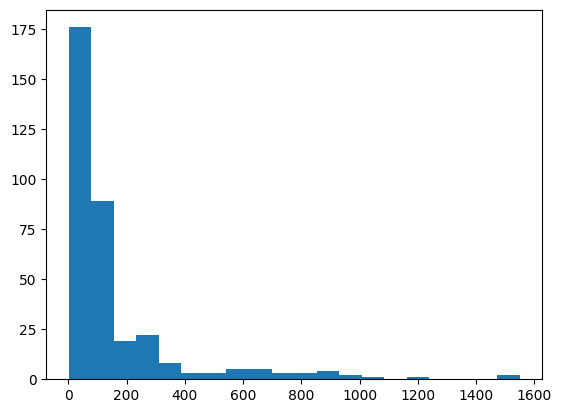

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 20)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 17


###  Tokenizar

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences

[[2171],
 [16,
  97,
  2865,
  11,
  27,
  187,
  6,
  772,
  1704,
  82,
  4,
  143,
  773,
  555,
  23,
  344,
  4289,
  4290,
  2866,
  1205,
  115,
  6,
  2172,
  2867,
  774,
  112,
  1705,
  2173,
  3,
  38,
  4291,
  883,
  2868,
  6,
  1706,
  1707,
  10,
  98,
  1,
  4292,
  25,
  258,
  2869,
  26,
  4,
  2870,
  6,
  2172,
  2,
  83,
  94,
  4293,
  51,
  26,
  4294,
  5,
  2871,
  5,
  2174,
  42,
  344,
  507,
  48,
  132,
  3,
  127,
  1,
  2871,
  5,
  2174,
  11,
  29,
  113,
  1206,
  147,
  23,
  1,
  884,
  31,
  2175,
  3,
  148,
  147,
  466,
  38,
  2872,
  2873,
  25,
  45,
  6,
  144,
  1013,
  22,
  684,
  52,
  22,
  1445,
  3,
  300,
  2,
  2874,
  147,
  363,
  344,
  507,
  685,
  885,
  1,
  187,
  5,
  38,
  555,
  23,
  1,
  1205,
  115,
  774,
  686,
  344,
  507,
  38,
  556,
  6,
  2868,
  2,
  1,
  1014,
  4295,
  259,
  3,
  1706,
  3,
  2875,
  38,
  886,
  34,
  29,
  687,
  1,
  423,
  188,
  4296,
  886,
  2,
  4297,
  2876,
  23,
  1,
  1205,
 

In [ ]:
max_context_size+1

18

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [ ]:
len(tok_sent)

34772

#### Haciendo data augmentation:

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(590845, 18)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'and',
 3: 'to',
 4: 'a',
 5: 'of',
 6: 'in',
 7: 'for',
 8: 'is',
 9: 'you',
 10: 'that',
 11: 'with',
 12: 'on',
 13: 'as',
 14: 'your',
 15: 'it',
 16: 'this',
 17: 'or',
 18: 'can',
 19: 'be',
 20: 'are',
 21: 'from',
 22: 'i',
 23: 'at',
 24: 'have',
 25: 'was',
 26: 'by',
 27: 'an',
 28: 'what',
 29: 'their',
 30: 'how',
 31: 'he',
 32: 'they',
 33: 'should',
 34: 'about',
 35: 'more',
 36: 'will',
 37: 'but',
 38: 'his',
 39: 'all',
 40: 'we',
 41: 'use',
 42: 'when',
 43: 'marketing',
 44: 'well',
 45: 'not',
 46: 'has',
 47: 'time',
 48: 'who',
 49: 'if',
 50: 'our',
 51: 'up',
 52: 'them',
 53: 'also',
 54: 'one',
 55: 'which',
 56: 'do',
 57: 'provide',
 58: 'so',
 59: 'make',
 60: 'like',
 61: 'write',
 62: 'any',
 63: 'my',
 64: 'its',
 65: 'there',
 66: 'out',
 67: 'include',
 68: 'new',
 69: 'other',
 70: 'get',
 71: 'these',
 72: 'some',
 73: 'such',
 74: 'said',
 75: 'into',
 76: 'her',
 77: '1',
 78: 'over',
 79: 'based',
 80: 'just',
 81: 'first',
 82:

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

8414

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'and': 2, 'to': 3, 'a': 4, 'of': 5, 'in': 6, 'for': 7, 'is': 8, 'you': 9, 'that': 10, 'with': 11, 'on': 12, 'as': 13, 'your': 14, 'it': 15, 'this': 16, 'or': 17, 'can': 18, 'be': 19, 'are': 20, 'from': 21, 'i': 22, 'at': 23, 'have': 24, 'was': 25, 'by': 26, 'an': 27, 'what': 28, 'their': 29, 'how': 30, 'he': 31, 'they': 32, 'should': 33, 'about': 34, 'more': 35, 'will': 36, 'but': 37, 'his': 38, 'all': 39, 'we': 40, 'use': 41, 'when': 42, 'marketing': 43, 'well': 44, 'not': 45, 'has': 46, 'time': 47, 'who': 48, 'if': 49, 'our': 50, 'up': 51, 'them': 52, 'also': 53, 'one': 54, 'which': 55, 'do': 56, 'provide': 57, 'so': 58, 'make': 59, 'like': 60, 'write': 61, 'any': 62, 'my': 63, 'its': 64, 'there': 65, 'out': 66, 'include': 67, 'new': 68, 'other': 69, 'get': 70, 'these': 71, 'some': 72, 'such': 73, 'said': 74, 'into': 75, 'her': 76, '1': 77, 'over': 78, 'based': 79, 'just': 80, 'first': 81, 'after': 82, 'had': 83, 'she': 84, 'budget': 85, 'than': 86, 'were': 87, 'including'

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'prompt': 3, 'once': 15, 'long': 22, 'find': 26, 'an': 91, 'have': 81, 'my': 26, 'third': 17, 'set': 19, 'story': 30, 'myself': 4, 'return': 8, 'wakad': 1, 'completed': 4, 'based': 52, 'oblivious': 1, 'been': 34, 'grandfather': 1, 'told': 6, 'books': 8, 'had': 25, 'depression': 2, 'not': 57, 'centre': 6, 'six': 7, 'arrived': 2, 'years': 30, 'provided': 9, 'family’s': 1, 'says': 5, 'over': 44, 'said': 16, 'it’s': 15, 'each': 43, 'can': 110, 'unwashed': 1, 'vinode': 1, 'still': 19, 'say': 8, '1990s': 1, 'ranking': 1, 'hemalkasa': 1, 'case': 10, 'court': 7, 'mental': 6, 'by': 95, 'magsaysay': 1, 'resolutely': 1, 'illness': 3, 'anything': 10, 'never': 14, 'changed': 9, 'about': 82, 'cars': 3, 'staffers': 1, 'three': 23, 'will': 61, 'madia': 1, 'in': 225, 'baba': 1, 'same': 16, 'records': 3, 'that': 172, 'sold': 4, 'spark”': 1, 'everything': 8, 'pushing': 3, 'some': 45, 'bus': 2, 'ends': 3, 'car': 5, '“that': 1, 'just': 27, 'pune': 1, 'passage': 29, 'performed': 


### Definir el modelo

Para el modelo abajo, hicimos algunos cambios:
 - Agregamos una capa más de LSTM y otra de Dropout
 - Sacamos la capa densa
 - Y utilizamos SparseCategoricalAccuracy como metrica de precisión para el modelo
 - Dejamos la metrica standard de precisión 'acurracy' para comparación

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=24, input_shape=(max_context_size,)))

model.add(LSTM(256, return_sequences=True)) # Increased LSTM units and added return_sequences
model.add(Dropout(0.2)) # Added dropout for regularization
model.add(LSTM(256)) # Added another LSTM layer
model.add(Dropout(0.2)) # Added dropout for regularization

# Predicción de clasificación con softmax
model.add(Dense(vocab_size+1, activation='softmax'))

model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=[SparseCategoricalAccuracy()])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 17, 24)              │         201,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 17, 256)             │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 17, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8415)                │       2,162,655 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,177,671 (12.12 MB)

 Trainable params: 3,177,671 (12.12 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.accuracy_metric = SparseCategoricalAccuracy()
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])
        self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

        self.info.append((count,count+len_seq))
        count += len_seq

      self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        # Calculamos accuracy aca para comparar con la otra metrica
        predictions = self.model.predict(self.padded, verbose=0)
        self.accuracy_metric.update_state(self.target, predictions)
        accuracy = self.accuracy_metric.result().numpy()
        logs['accuracy'] = accuracy
        self.accuracy_metric.reset_state()

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)}, Accuracy: {accuracy}\n')

### Entrenamiento

In [ ]:
# Elegimos 100 epochs y aumentamos el batch para 700, ese cambio resultó en un mejor tiempo de entrenamiento por epoch.
hist = model.fit(X, y, epochs=100, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=700)

Epoch 1/100
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.2644 - sparse_categorical_accuracy: 0.0555
 mean perplexity: 3517.229731288356, Accuracy: 0.07444300502538681

845/845 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - loss: 7.2637 - sparse_categorical_accuracy: 0.0555 - accuracy: 0.0744
Epoch 2/100
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.2805 - sparse_categorical_accuracy: 0.0867
 mean perplexity: 6199.531706232588, Accuracy: 0.07520340383052826

845/845 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - loss: 6.2802 - sparse_categorical_accuracy: 0.0867 - accuracy: 0.0752
Epoch 3/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.7981 - sparse_categorical_accuracy: 0.0974
 mean perplexity: 9120.517097775368, Accuracy: 0.07155349105596542

845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - loss: 5.7980 - sparse_categorical_accuracy: 0.0974 - accuracy: 0.0716
Epoch 4/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.4245 - sparse_categorical_accuracy: 0.1064
 mean perplexity: 12637

<ipython-input-100-4e10a8ac1ea7>:54: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))


844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.7611 - sparse_categorical_accuracy: 0.4106
 mean perplexity: inf, Accuracy: 0.07216181606054306

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 2.7611 - sparse_categorical_accuracy: 0.4106 - accuracy: 0.0722
Epoch 24/100
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.6843 - sparse_categorical_accuracy: 0.4247
 mean perplexity: inf, Accuracy: 0.07208577543497086

845/845 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - loss: 2.6842 - sparse_categorical_accuracy: 0.4247 - accuracy: 0.0721
Epoch 25/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.6063 - sparse_categorical_accuracy: 0.4397
 mean perplexity: inf, Accuracy: 0.07026081532239914

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - loss: 2.6063 - sparse_categorical_accuracy: 0.4397 - accuracy: 0.0703
Epoch 26/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.5384 - sparse_categorical_accuracy: 0.4501
 mean perplexity: inf, Accuracy: 0.07223784923553467

845/845 ━━━━━━━━━━━━

In [ ]:
print(hist.history.keys()) # Vemos las keys disponibles y identificamos las metricas disponibles:

dict_keys(['loss', 'sparse_categorical_accuracy', 'accuracy'])


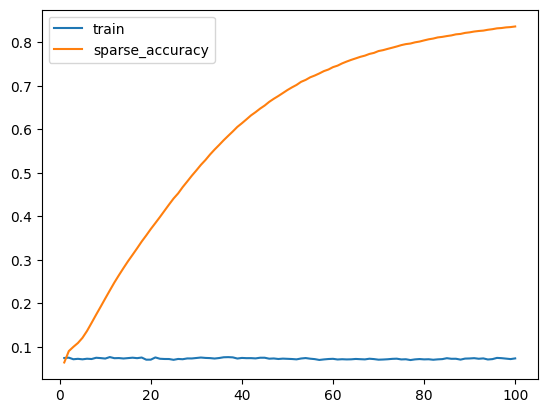

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['sparse_categorical_accuracy'], label='sparse_accuracy')
plt.show()


### Predicción de próxima palabra

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c05dbc39017412d1bc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c05dbc39017412d1bc.gradio.live


### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='the objective'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'the objective of avalon’s lifelong residents'

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="when I ask")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━

In [ ]:
# veamos las salidas
decode(salidas[0])

['when i ask for love toad in the hole']

### Conclusiones:
#### - Utilizamos solo una fración del dataset para la prueba, el entrenamiento llevó cerca de 40 minutos para concluir y resultó en resultados aceptables debido a cantidad de datos de ingesta y modelo planteado.
#### - El valor final de la precisión es el indicador final de rendimiento del modelo, el valor final alto del sparse_categorical_accuracy indica un buen rendimiento en la predicción de palabras.
